### Dependencies

##### Installation

In [48]:
%pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


##### Imports

In [57]:
from rembg import remove
import cv2
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

### Remove background of pH strip

##### Remove background

In [44]:
input_path = 'assets/strip.png'
output_path = 'output/strip_withouth_bg.png'

input = cv2.imread(input_path)
output = remove(input)
cv2.imwrite(output_path, output)

True

##### Plot strips

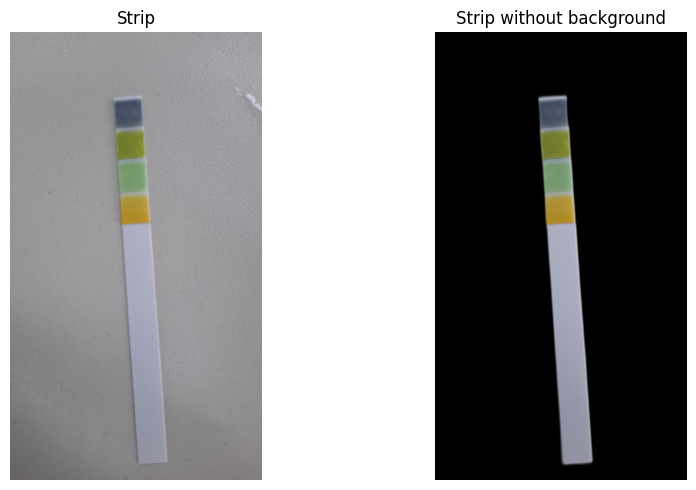

In [45]:
strip = cv2.imread(input_path)
strip_without_bg = cv2.imread(output_path)


strip_rgb = cv2.cvtColor(strip, cv2.COLOR_BGR2RGB)
strip_without_bg_rgb = cv2.cvtColor(strip_without_bg, cv2.COLOR_BGR2RGB)


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(strip_rgb)
axs[0].set_title('Strip')
axs[0].axis('off')

axs[1].imshow(strip_without_bg_rgb)
axs[1].set_title('Strip without background')
axs[1].axis('off')

plt.tight_layout()
plt.show()

### Balance strip

##### Rotate strip

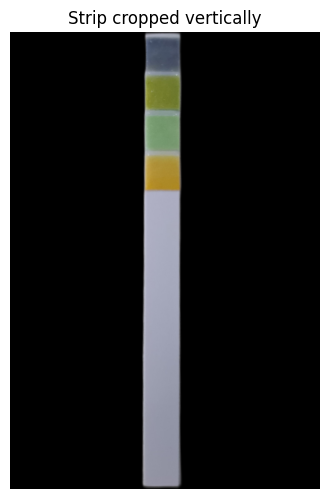

In [52]:
image_without_bg = cv2.imread('output/strip_withouth_bg.png')
gray = cv2.cvtColor(image_without_bg, cv2.COLOR_BGR2GRAY)

_, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

largest_contour = max(contours, key=cv2.contourArea)

rect = cv2.minAreaRect(largest_contour)
box = cv2.boxPoints(rect)
box = np.intp(box)

angle = rect[-1]
width, height = rect[1]

if width < height:
    corrected_angle = angle
else:
    corrected_angle = angle + 90

(h, w) = image_without_bg.shape[:2]
center = (w // 2, h // 2)

M = cv2.getRotationMatrix2D(center, corrected_angle, 1.0)
rotated = cv2.warpAffine(image_without_bg, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))
rotated = cv2.flip(rotated, 0)

gray_rotated = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
_, binary_rotated = cv2.threshold(gray_rotated, 10, 255, cv2.THRESH_BINARY)

contours, _ = cv2.findContours(binary_rotated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
largest_contour = max(contours, key=cv2.contourArea)

x, y, w, h = cv2.boundingRect(largest_contour)

cropped = rotated[y:y+h, :]

plt.figure(figsize=(4, 8))
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Strip cropped vertically')
plt.show()


##### Colour balance

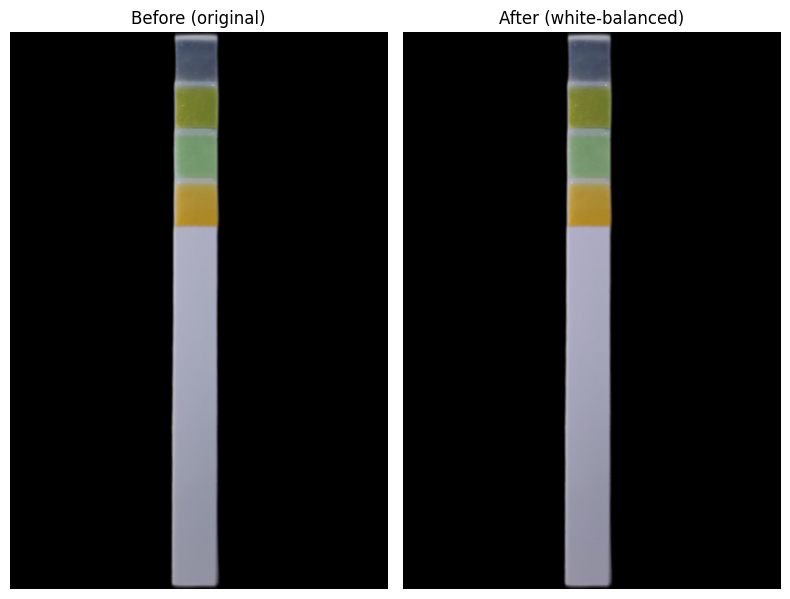

In [ ]:
def white_balance_gray_world(img):
    result = img.copy().astype(np.float32)

    avg_b = np.mean(result[:, :, 0])
    avg_g = np.mean(result[:, :, 1])
    avg_r = np.mean(result[:, :, 2])

    avg_gray = (avg_b + avg_g + avg_r) / 3

    result[:, :, 0] *= avg_gray / avg_b
    result[:, :, 1] *= avg_gray / avg_g
    result[:, :, 2] *= avg_gray / avg_r

    result = np.clip(result, 0, 255).astype(np.uint8)
    return result

white_balanced = white_balance_gray_world(cropped)

fig, axs = plt.subplots(1, 2, figsize=(8, 10))
3
axs[0].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
axs[0].set_title('Before (original)')
axs[0].axis('off')

axs[1].imshow(cv2.cvtColor(white_balanced, cv2.COLOR_BGR2RGB))
axs[1].set_title('After (white-balanced)')
axs[1].axis('off')

plt.tight_layout()
plt.show()


### Extract RGBA

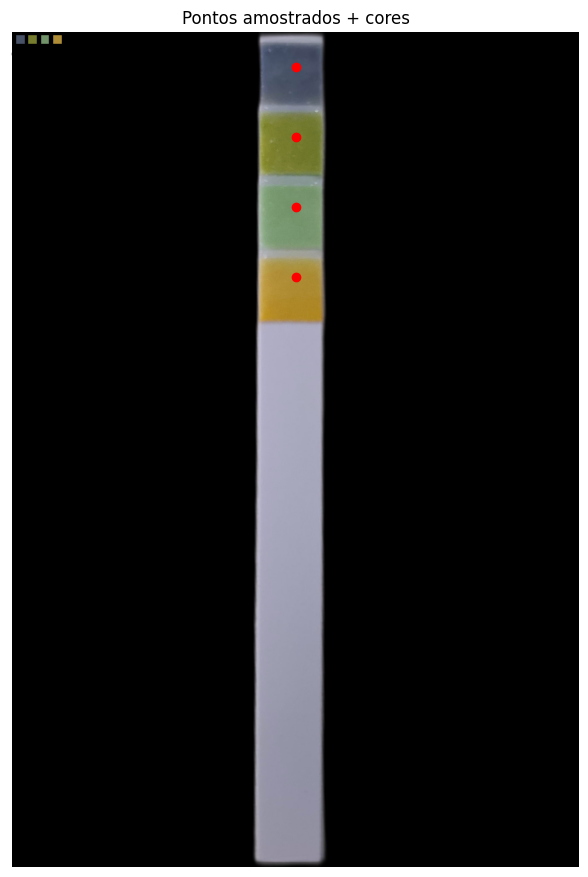

In [ ]:
height_px = white_balanced.shape[0]
fita_cm = 16.7

x_center = white_balanced.shape[1] // 2

medidas_cm = {
    'Q1': 0.7,
    'Q2': 2.1,
    'Q3': 3.5,
    'Q4': 4.9,
}
def cm_to_px(cm):
    return int((cm / fita_cm) * height_px)

points = {label: (x_center, cm_to_px(cm)) for label, cm in medidas_cm.items()}

fig, ax = plt.subplots(figsize=(6, 10))
ax.imshow(cv2.cvtColor(white_balanced, cv2.COLOR_BGR2RGB))
ax.axis('off')
ax.set_title('Pontos amostrados + cores')

swatch_size = 40
for i, (label, (x, y)) in enumerate(points.items()):
    color_bgr = white_balanced[y, x]
    color_rgb = tuple(int(c) for c in color_bgr[::-1])

    ax.plot(x, y, 'ro', markersize=6)

    swatch_x = 10 + i * (swatch_size + 10)
    swatch_y = 10
    rect = Rectangle((swatch_x, swatch_y), swatch_size, swatch_size,
                     linewidth=1, edgecolor='black', facecolor=np.array(color_rgb) / 255)
    ax.add_patch(rect)
    ax.text(swatch_x + swatch_size / 2, swatch_y + swatch_size + 12,
            label, ha='center', va='top', fontsize=10)

plt.tight_layout()
plt.show()

